Satellite imagery provides unique insights into various markets, including agriculture, defense and intelligence, energy, and finance. New commercial imagery providers, such as Planet and BlackSky, are using constellations of small satellites to exponentially increase the amount of images of the earth captured every day.

This flood of new imagery is outgrowing the ability for organizations to manually look at each image that gets captured, and there is a need for machine learning and computer vision algorithms to help automate the analysis process.

The aim of this dataset is to help address the difficult task of detecting the location of airplanes in satellite images. Automating this process can be applied to many issues including monitoring airports for activity and traffic patterns, and defense intelligence.

Perform the following steps to obtain and situate your dataset:

1. Go to this link https://www.kaggle.com/rhammell/planesnet/data
2. On the left-hand side, under “Data” select “planesnet.zip”
3. Select “Download”
4. After this compressed file has finished downloading, extract it to any location on your computer
    Viewing the extracted “planesnet” folder, you should see a bunch of PNG image files with seemingly nonsensical names like “0__20140723_181317_0905__-122.14328662_37.697282118.png”

# Data Preprocessing

In [1]:
# Imports
import glob
import numpy as np
import os.path as path
from scipy import misc

Retrieve the filename of all images in the IMAGE_PATH

In [2]:
# IMAGE_PATH should be the path to the downloaded planesnet folder
IMAGE_PATH = 'planesnet'
file_paths = glob.glob(path.join(IMAGE_PATH, '*.png'))

In [ ]:
# Load the images into a single variable and convert to a numpy array
# Load the images
images = [imageio.imread(path) for path in file_paths]
images = np.asarray(images)

In [5]:
# Retrieve the size of the images
# Get image size
image_size = np.asarray([images.shape[1], images.shape[2], images.shape[3]])
print(image_size)

[20 20  3]


This image_size array will let us know the dimensions of the images. If we print this variable, we learn that the dimensions of the images are [20, 20, 3]. This means that each image in the dataset has 20 rows, 20 columns, and a depth of 3 (or 3 channels, Red, Green, and Blue). These numbers define the spatial resolution of the image.

Next we scale the images such that their values are between 0–1

In [6]:
# Scale
images = images / 255

The images we are working with are 8-bit. This means that each pixel in the image is one of 256 (2⁸ = 256) possible values. While some machine learning algorithms can handle having relatively large pixel values, most methods perform optimally (train within our lifetimes) when small, floating point values are processed. Hence we divide by 255 (0 is a possible pixel value as well, so 255 is actually the maximum value found within our data) to scale our data between 0–1. So, after this step, a value that was represented by an integer of 128, would now instead be represented by a floating point value of 128/255 = ~0.502. It is important to note that the appearance of the images will be fundamentally unaltered after this step.

The next step is to retrieve the image labels. As referenced above, these labels were manually annotated by a human being. Each 20 by 20 image was reviewed, and given a “1” (True) if it contained an airplane and a “0” (False) if it did not contain an airplane. 

We can extract these labels by reading in the first character in the image filename. For example, in the image filename “0__20140723_181317_0905__-122.14328662_37.697282118.png”, the very first “0” is indicating to us that this image does not contain an airplane. We can extract these labels with the following code:

In [7]:
# Read the labels from the filenames
n_images = images.shape[0]
labels = np.zeros(n_images)
for i in range(n_images):
    filename = path.basename(file_paths[i])[0]
    labels[i] = int(filename[0])

Great! Now we have a bunch of images and their corresponding labels. In the classic supervised machine learning lingo, we consider the images to be “X” and the labels to be “y”. The machine learning algorithm is going to find a function “f” such that for any given image, y = f(X). In other words, we are going to take the 1,200 (20 x 20 x 3 = 1,200) X values, run them through a function, f, and predict one singular value, y, that represents a classification of either “plane” or “not plane”.


The next step is to split our data into training and test sets. This practice is important, because it is the only way to evaluate your model in an unbiased way. Basically, you want your model to learn on the training set, (usually about 90% of all of the images you have available), and then report back its accuracy by evaluating it on the test set (the remaining 10%).

In [8]:
# Split into test and training sets
TRAIN_TEST_SPLIT = 0.9

# Split at the given index
split_index = int(TRAIN_TEST_SPLIT * n_images)
shuffled_indices = np.random.permutation(n_images)
train_indices = shuffled_indices[0:split_index]
test_indices = shuffled_indices[split_index:]

# Split the images and the labels
x_train = images[train_indices, :, :]
y_train = labels[train_indices]
x_test = images[test_indices, :, :]
y_test = labels[test_indices]

# Data Visualization

In [9]:
import matplotlib.pyplot as plt

In [10]:
#  visualization function
def visualize_data(positive_images, negative_images):
    # INPUTS
    # positive_images - Images where the label = 1 (True)
    # negative_images - Images where the label = 0 (False)

    figure = plt.figure()
    count = 0
    for i in range(positive_images.shape[0]):
        count += 1
        figure.add_subplot(2, positive_images.shape[0], count)
        plt.imshow(positive_images[i, :, :])
        plt.axis('off')
        plt.title("1")

        figure.add_subplot(1, negative_images.shape[0], count)
        plt.imshow(negative_images[i, :, :])
        plt.axis('off')
        plt.title("0")
    plt.show()

This function will plot positive and negative image examples for us. By “positive” we mean data with a label of “1” or “True”, and by “negative” we mean data with a label of “0” or “False”. We need negative examples (i.e. images that do not contain airplanes), because otherwise the model would not have any reference point and likely assume that the mere presence of an image is indicative that it contains an airplane. The inner workings of the visualize_data function create two rows of images where some number of positive examples are on the top, and the same number of negative examples are on the bottom. The titles above them indicate what their label is. Let’s take a look at what a call to this function looks like.

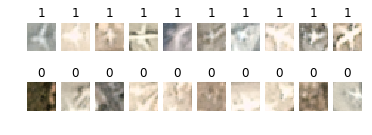

In [11]:
# Number of positive and negative examples to show
N_TO_VISUALIZE = 10

# Select the first N positive examples
positive_example_indices = (y_train == 1)
positive_examples = x_train[positive_example_indices, :, :]
positive_examples = positive_examples[0:N_TO_VISUALIZE, :, :]

# Select the first N negative examples
negative_example_indices = (y_train == 0)
negative_examples = x_train[negative_example_indices, :, :]
negative_examples = negative_examples[0:N_TO_VISUALIZE, :, :]

# Call the visualization function
visualize_data(positive_examples, negative_examples)

# Model Creation

In [12]:
# Imports
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import accuracy_score, f1_score
from datetime import datetime

Using TensorFlow backend.


In [13]:
# Hyperparamater
N_LAYERS = 4

In [14]:
def cnn(size, n_layers):
    # INPUTS
    # size     - size of the input images
    # n_layers - number of layers
    # OUTPUTS
    # model    - compiled CNN

    # Define hyperparamters
    MIN_NEURONS = 20
    MAX_NEURONS = 120
    KERNEL = (3, 3)

    # Determine the # of neurons in each convolutional layer
    steps = np.floor(MAX_NEURONS / (n_layers + 1))
    nuerons = np.arange(MIN_NEURONS, MAX_NEURONS, steps)
    nuerons = nuerons.astype(np.int32)

    # Define a model
    model = Sequential()

    # Add convolutional layers
    for i in range(0, n_layers):
        if i == 0:
            shape = (size[0], size[1], size[2])
            model.add(Conv2D(nuerons[i], KERNEL, input_shape=shape))
        else:
            model.add(Conv2D(nuerons[i], KERNEL))

        model.add(Activation('relu'))

    # Add max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(MAX_NEURONS))
    model.add(Activation('relu'))

    # Add output layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Print a summary of the model
    model.summary()

    return model

In [15]:
# Instantiate the model
model = cnn(size=image_size, n_layers=N_LAYERS)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 18, 18, 20)        560       
_________________________________________________________________
activation_1 (Activation)    (None, 18, 18, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 44)        7964      
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 44)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 68)        26996     
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 68)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 92)        56396     
__________

# Model Training

In [16]:
# Training hyperparamters
EPOCHS = 150
BATCH_SIZE = 200

In [17]:
# Early stopping callback
PATIENCE = 10
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=PATIENCE, verbose=0, mode='auto')

In [18]:
# TensorBoard callback
LOG_DIRECTORY_ROOT = ''
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
log_dir = "{}/run-{}/".format(LOG_DIRECTORY_ROOT, now)
tensorboard = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)

In [20]:
# Place the callbacks in a list
callbacks = [early_stopping, tensorboard]

In [ ]:
# Train the model
model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=0)

# Model Evaluation

In [ ]:
# Make a prediction on the test set
test_predictions = model.predict(x_test)
test_predictions = np.round(test_predictions)

In [ ]:
# Report the accuracy
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: " + str(accuracy))

In [ ]:
import matplotlib.pyplot as plt
def visualize_incorrect_labels(x_data, y_real, y_predicted):
    # INPUTS
    # x_data      - images
    # y_data      - ground truth labels
    # y_predicted - predicted label
    count = 0
    figure = plt.figure()
    incorrect_label_indices = (y_real != y_predicted)
    y_real = y_real[incorrect_label_indices]
    y_predicted = y_predicted[incorrect_label_indices]
    x_data = x_data[incorrect_label_indices, :, :, :]

    maximum_square = np.ceil(np.sqrt(x_data.shape[0]))

    for i in range(x_data.shape[0]):
        count += 1
        figure.add_subplot(maximum_square, maximum_square, count)
        plt.imshow(x_data[i, :, :, :])
        plt.axis('off')
        plt.title("Predicted: " + str(int(y_predicted[i])) + ", Real: " + str(int(y_real[i])), fontsize=10)

    plt.show()

visualize_incorrect_labels(x_test, y_test, np.asarray(test_predictions).ravel())

False Positives: We can see from the images that our model is fooled by roads that appear to take the shape of an airplane. Additionally, if there is a large white spot in the image, the model might also incorrectly predict that an airplane is present. Images that contain partial planes also can result in false positives.

False Negatives: Airplanes that are non-white in color seem to throw off the model. The model also has trouble detecting airplanes with unusual wing shapes.